# Load Spotify Dataset

In [5]:
# Load the dataset
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/611noorsaeed/Music-Recommendation-System-using-Spotify-Dataset/refs/heads/main/clustered_df.csv")  # Replace with the actual dataset path
df = df.sample(n=5000,random_state=42).reset_index(drop=True)
df.head()

,Unnamed: 0,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,...,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,Cluster
0,1501,0.6880,1980,0.0311,['Nazareth'],0.615,216253,0.834,0,4HoTskE5N0oEM4CKRfuzFI,...,7,0.1430,-5.726,1,Holiday,29,1980,0.0318,131.606,1
1,2586,0.0391,1942,0.9890,"['Giacomo Puccini', 'Leontyne Price', 'Erich L...",0.290,299120,0.167,0,2VtUcZ1yowXnhotD3yPAaW,...,1,0.2900,-15.035,1,"Un bel dì (From ""Madama Butterfly"")",0,1942,0.0450,104.500,2
2,2653,0.9620,1950,0.6350,['La Sonora Santanera'],0.679,181933,0.486,0,0rd7q2ibicTeKNbLUl3gTV,...,7,0.3610,-10.397,0,Pena Negra,27,1950,0.0337,131.198,0
3,1055,0.5900,1971,0.2420,['Jimi Hendrix'],0.460,249920,0.720,0,11t59LqOhOEG40yqALXZon,...,1,0.5280,-11.263,1,Ezy Ryder,38,1971,0.0525,123.548,4
4,705,0.8520,2005,0.1390,['Alabama'],0.747,214880,0.460,0,6WJKrF37Bz6CKr3fOtxJHS,...,7,0.0801,-12.797,1,The Closer You Get,40,2005-05-17,0.0280,114.254,1


# Features and Scaling

In [6]:
# Select relevant numerical features for clustering
from sklearn.preprocessing import StandardScaler

numerical_features = [
    "valence", "danceability", "energy", "tempo", 
    "acousticness", "liveness", "speechiness", "instrumentalness"
]

# Standardize the numerical features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)

# Train Test Split

In [7]:
# Optional: Split for testing or validation
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_scaled, test_size=0.2, random_state=42)

# Elbow Method Plot
To find optimal K

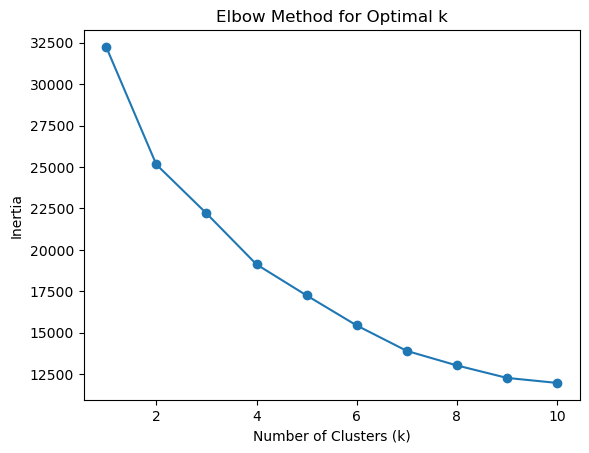

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


# Applying Kmeans

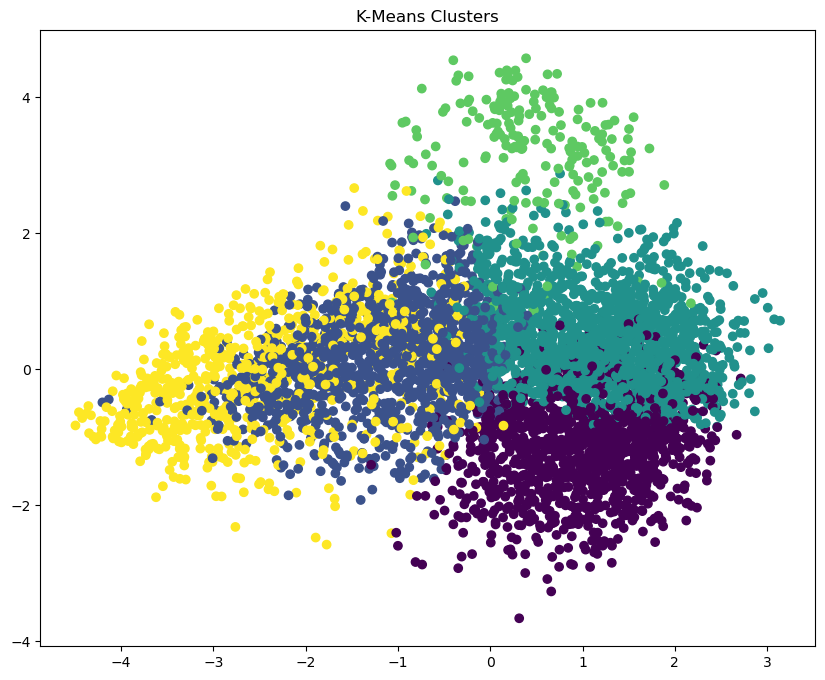

In [9]:
# Apply K-Means clustering with optimal k (e.g., k=5)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df["Cluster"] = kmeans.fit_predict(df_scaled)

# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

plt.figure(figsize=(10,8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df["Cluster"], cmap="viridis")
plt.title("K-Means Clusters")
plt.show()

# Recommendation System With Kmeans

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_songs(song_name, df, num_recommendations=5):
    # Get the cluster of the input song
    song_cluster = df[df["name"] == song_name]["Cluster"].values[0]

    # Filter songs from the same cluster
    same_cluster_songs = df[df["Cluster"] == song_cluster]

    # Calculate similarity within the cluster
    song_index = same_cluster_songs[same_cluster_songs["name"] == song_name].index[0]
    cluster_features = same_cluster_songs[numerical_features]
    similarity = cosine_similarity(cluster_features, cluster_features)

    # Get top recommendations
    similar_songs = np.argsort(similarity[song_index])[-(num_recommendations + 1):-1][::-1]
    recommendations = same_cluster_songs.iloc[similar_songs][["name", "year", "artists"]]

    return recommendations

In [11]:
# Example usage
input_song =  "Camby Bolongo"
recommended_songs = recommend_songs(input_song, df, num_recommendations=5)

print(f"Songs similar to '{input_song}':")
recommended_songs

IndexError: index 1881 is out of bounds for axis 0 with size 1570

In [ ]:
# Example usage
input_song = "Soul Junction"
recommended_songs = recommend_songs(input_song, df, num_recommendations=5)

print(f"Songs similar to '{input_song}':")
recommended_songs

Songs similar to 'Soul Junction':


,name,year,artists
1088,Legends of the Fall,1995,"['James Horner', 'Vic Frasier']"
3489,"Water Music Suite No. 1 In F, HWV 348: 2. Adag...",1983,"['George Frideric Handel', 'The English Concer..."
2473,"Le sacre du printemps: Part 1 ""Adoration of th...",1948,"['Igor Stravinsky', 'Columbia Symphony Orchest..."
1277,Saving Buckbeak,2004,['John Williams']
3385,"Tristan und Isolde, WWV 90: Prelude",1953,"['Richard Wagner', 'Arturo Toscanini']"


In [ ]:
# save df
df.to_csv("clustered_df.csv")

In [12]:
import pickle

# Save both KMeans model and scaler
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump({"model": kmeans, "scaler": scaler}, f)
